In [1]:
!source tf_env/bin/activate

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-11-08 21:01:24.071902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 21:01:24.299133: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 21:01:24.352215: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 21:01:25.272110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/example_imagess/train.tar.gz"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


611809929/611809929 [==============================] - 47s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

36852


In [6]:
import tensorflow as tf
import pathlib

# ... (previous code) ...

# Assuming 'data_dir' contains the path to your image dataset directory
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', # Labels are inferred from the directory structure
    label_mode='int', # Labels are encoded as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Resize images
    batch_size=BATCH_SIZE, # Define batch size
    shuffle=True # Shuffle the dataset
)

class_names = dataset.class_names # Get class names from the dataset object
print(class_names)

Found 39152 files belonging to 21 classes.


2024-11-08 21:02:37.543182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 21:02:39.519593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 73718 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-11-08 21:02:39.521364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78910 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:31:00.0, compute capability: 8.0


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 1 12  9  2 10 20 14 18 11 14 10 15 18 14  2  0  9 11  1 11 10 19 16  1
  1  2  2 11 11 13  3 16]


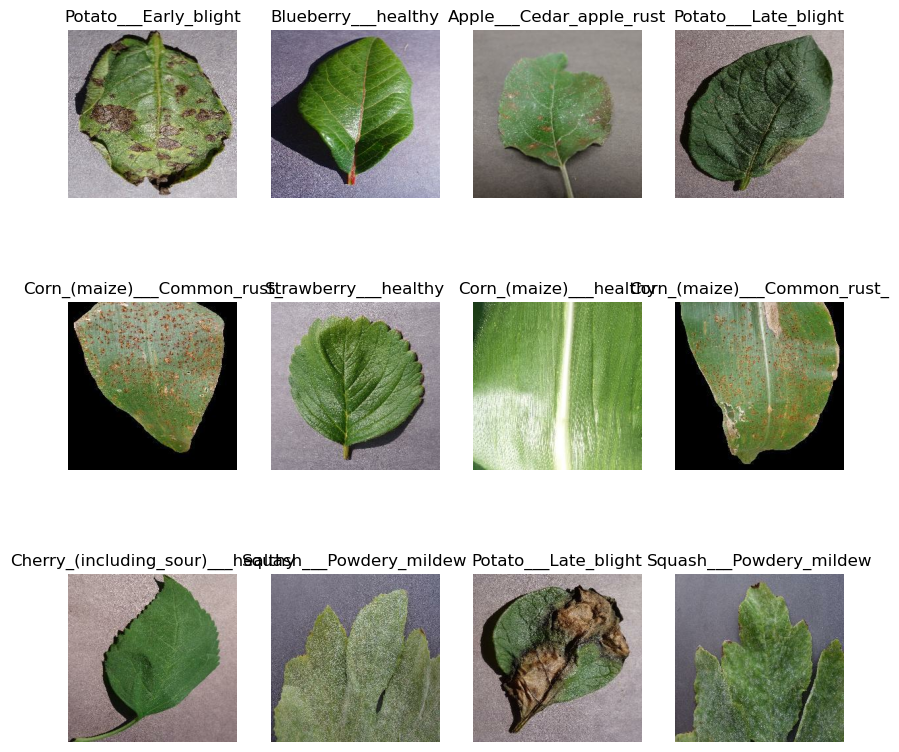

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

1224

In [10]:
train_size = 0.8
len(dataset)*train_size

979.2

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)


1170

In [13]:
val_size=0.1
len(dataset)*val_size

122.4

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

1164

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

979

In [19]:
len(val_ds)

122

In [20]:
len(test_ds)

123

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
from tensorflow.keras import layers

# Define the resizing and rescaling layer without using the experimental namespace
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to target size
    layers.Rescaling(1./255)  # Scale pixel values to [0, 1]
])

In [23]:
# Data augmentation layer without the experimental namespace
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.2),  # Randomly rotate images by 20%
])


In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 21

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20


2024-11-08 21:03:24.555007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8905
2024-11-08 21:03:25.089913: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


979/979 [==============================] - 126s 119ms/step - loss: 1.6384 - accuracy: 0.4551 - val_loss: 0.9348 - val_accuracy: 0.7167
Epoch 2/20
979/979 [==============================] - 110s 112ms/step - loss: 0.6303 - accuracy: 0.7841 - val_loss: 0.6972 - val_accuracy: 0.7920
Epoch 3/20
979/979 [==============================] - 114s 116ms/step - loss: 0.3997 - accuracy: 0.8651 - val_loss: 0.3296 - val_accuracy: 0.8863
Epoch 4/20
979/979 [==============================] - 111s 113ms/step - loss: 0.2989 - accuracy: 0.8982 - val_loss: 0.3956 - val_accuracy: 0.8696
Epoch 5/20
979/979 [==============================] - 110s 112ms/step - loss: 0.2359 - accuracy: 0.9193 - val_loss: 0.3004 - val_accuracy: 0.8993
Epoch 6/20
979/979 [==============================] - 109s 112ms/step - loss: 0.2040 - accuracy: 0.9314 - val_loss: 0.2308 - val_accuracy: 0.9219
Epoch 7/20
979/979 [==============================] - 112s 114ms/step - loss: 0.1762 - accuracy: 0.9390 - val_loss: 0.2623 - val_accura

In [29]:
scores = model.evaluate(test_ds)

123/123 [==============================] - 9s 20ms/step - loss: 0.1854 - accuracy: 0.9395


In [30]:
scores

[0.18536192178726196, 0.9395325183868408]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 979}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

20

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.638356328010559,
 0.630333423614502,
 0.39969319105148315,
 0.2989022135734558,
 0.23588281869888306]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

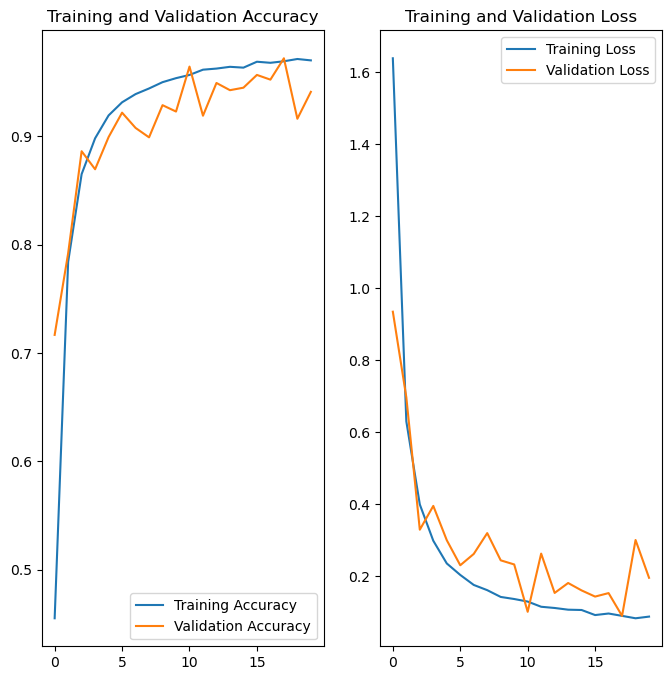

In [38]:
epochs_range = range(len(acc))  # or use range(EPOCHS) if arrays match EPOCHS

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 249ms/step
predicted label: Potato___Late_blight


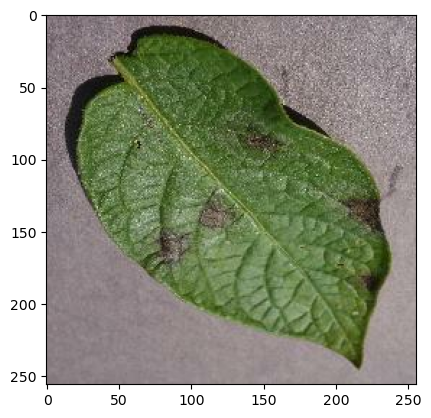

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


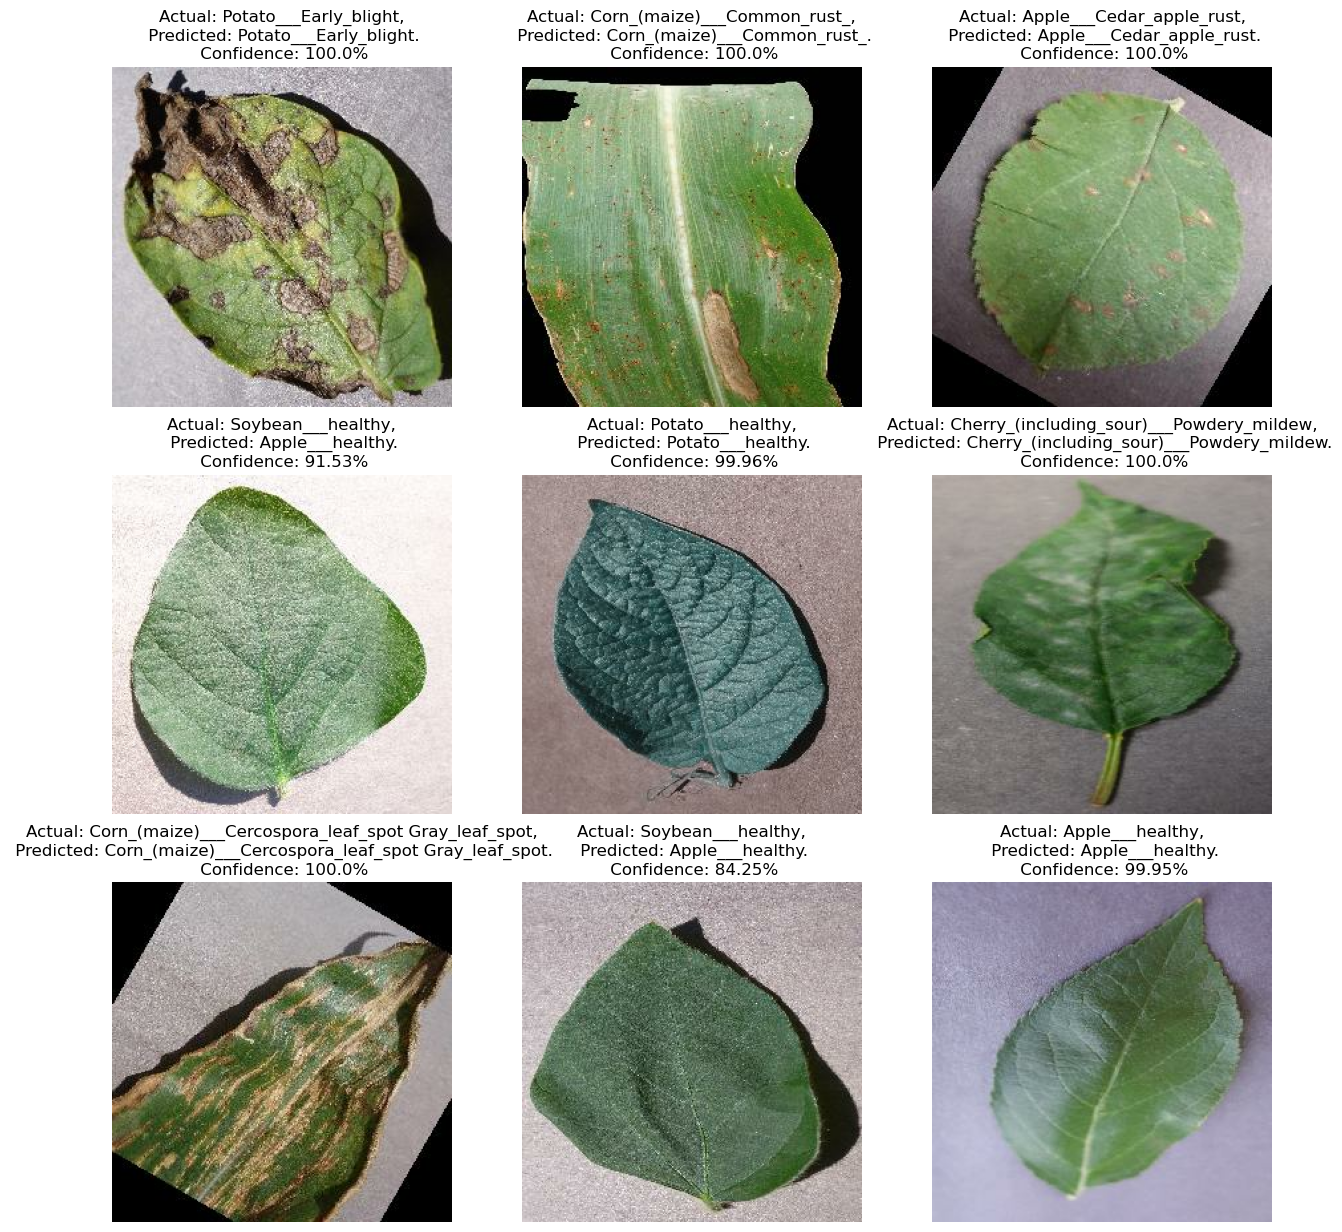

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [43]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


In [44]:
model.save("../PlantDisease.h5")